In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import tensorflow_datasets as tfds
# Deep Learning Libraries
from tensorflow.python import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPool2D, BatchNormalization,ZeroPadding2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
from keras.utils import plot_model
from IPython.display import SVG

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('testX.csv')
#train_df.shape
Y = train_df['Label']
train_x = train_df.drop('Id',axis=1)
X = train_x.drop('Label',axis=1)

test_x = test_df.drop('Id',axis=1)
print(X.shape)
print(test_x.shape)

(60000, 784)
(10000, 784)


In [ ]:
# Splitting Data into Train and Validation Set
seed = 42
np.random.seed(seed)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=seed)
print(x_train.shape)
print(x_val.shape)

(54000, 784)
(6000, 784)


In [ ]:
x_train = x_train.values.reshape((-1, 28, 28, 1))
x_val = x_val.values.reshape((-1, 28, 28, 1))
test_x = test_x.values.reshape((-1, 28, 28, 1))

x_train = x_train.astype("float32")/255
x_val = x_val.astype("float32")/255
test_x = test_x.astype("float32")/255


In [ ]:
print("Fashion MNIST train -  rows:",x_train.shape[0]," columns:", x_train.shape[1:4])
print("Fashion MNIST valid -  rows:",x_val.shape[0]," columns:", x_val.shape[1:4])
print("Fashion MNIST test -  rows:",test_x.shape[0]," columns:", test_x.shape[1:4])

Fashion MNIST train -  rows: 54000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 6000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


In [ ]:
y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)
print(y_train.shape)
print(y_val.shape)

(54000, 5)
(6000, 5)


In [ ]:
import tensorflow as tf



class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


class BottleNeck(tf.keras.layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(BottleNeck, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=filter_num * 4,
                                            kernel_size=(1, 1),
                                            strides=1,
                                            padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.downsample = tf.keras.Sequential()
        self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num * 4,
                                                   kernel_size=(1, 1),
                                                   strides=stride))
        self.downsample.add(tf.keras.layers.BatchNormalization())

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv3(x)
        x = self.bn3(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output


def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


def make_bottleneck_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BottleNeck(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BottleNeck(filter_num, stride=1))

    return res_block



class ResNetTypeI(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeI, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_basic_block_layer(filter_num=64,
                                             blocks=layer_params[0])
        self.layer2 = make_basic_block_layer(filter_num=128,
                                             blocks=layer_params[1],
                                             stride=2)
        self.layer3 = make_basic_block_layer(filter_num=256,
                                             blocks=layer_params[2],
                                             stride=2)
        self.layer4 = make_basic_block_layer(filter_num=512,
                                             blocks=layer_params[3],
                                             stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=5, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


class ResNetTypeII(tf.keras.Model):
    def __init__(self, layer_params):
        super(ResNetTypeII, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")

        self.layer1 = make_bottleneck_layer(filter_num=64,
                                            blocks=layer_params[0])
        self.layer2 = make_bottleneck_layer(filter_num=128,
                                            blocks=layer_params[1],
                                            stride=2)
        self.layer3 = make_bottleneck_layer(filter_num=256,
                                            blocks=layer_params[2],
                                            stride=2)
        self.layer4 = make_bottleneck_layer(filter_num=512,
                                            blocks=layer_params[3],
                                            stride=2)

        self.avgpool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc = tf.keras.layers.Dense(units=5, activation=tf.keras.activations.softmax)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.layer2(x, training=training)
        x = self.layer3(x, training=training)
        x = self.layer4(x, training=training)
        x = self.avgpool(x)
        output = self.fc(x)

        return output


def resnet_18():
    return ResNetTypeI(layer_params=[2, 2, 2, 2])


def resnet_34():
    return ResNetTypeI(layer_params=[3, 4, 6, 3])


def resnet_50():
    return ResNetTypeII(layer_params=[3, 4, 6, 3])
model = resnet_18()
model.build(input_shape = (None, 28, 28, 1))
model.summary()

Model: "res_net_type_i_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_601 (Conv2D)          multiple                  3200      
_________________________________________________________________
batch_normalization_564 (Bat multiple                  256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling multiple                  0         
_________________________________________________________________
sequential_79 (Sequential)   multiple                  148736    
_________________________________________________________________
sequential_80 (Sequential)   multiple                  527488    
_________________________________________________________________
sequential_82 (Sequential)   multiple                  2103552   
_________________________________________________________________
sequential_84 (Sequential)   multiple             

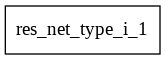

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


In [ ]:
optimizer = tf.keras.optimizers.Adam()

In [ ]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 50 # for better result increase the epochs
batch_size = 128

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range = 10, horizontal_flip = True, zoom_range = 0.1)

datagen.fit(x_train)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [ lr_reducer]
history1=model.fit(x_train, y_train,
     batch_size=batch_size,
     epochs=epochs,
     validation_data=(x_val, y_val),
     shuffle=True,
     callbacks=callbacks)

Epoch 1/50
422/422 [==============================] - 18s 43ms/step - loss: 0.5181 - accuracy: 0.8027 - val_loss: 0.6779 - val_accuracy: 0.7127 - lr: 0.0010
Epoch 2/50
422/422 [==============================] - 18s 42ms/step - loss: 0.3846 - accuracy: 0.8451 - val_loss: 1.2003 - val_accuracy: 0.7090 - lr: 0.0010
Epoch 3/50
422/422 [==============================] - 18s 42ms/step - loss: 0.3493 - accuracy: 0.8579 - val_loss: 0.3976 - val_accuracy: 0.8345 - lr: 0.0010
Epoch 4/50
422/422 [==============================] - 18s 42ms/step - loss: 0.3224 - accuracy: 0.8679 - val_loss: 0.3805 - val_accuracy: 0.8488 - lr: 0.0010
Epoch 5/50
422/422 [==============================] - 18s 42ms/step - loss: 0.3025 - accuracy: 0.8764 - val_loss: 1.7083 - val_accuracy: 0.6383 - lr: 0.0010
Epoch 6/50
422/422 [==============================] - 18s 43ms/step - loss: 0.2904 - accuracy: 0.8821 - val_loss: 0.3504 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 7/50
422/422 [==============================] - 18s 

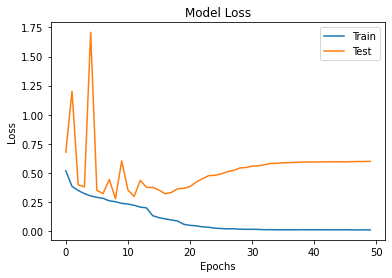

In [ ]:
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

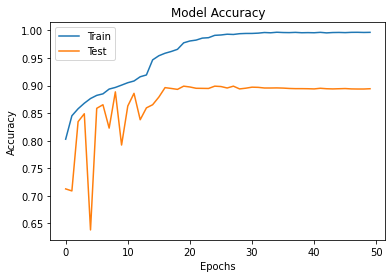

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
preds = model.predict_classes(test_x)
print(preds)
output=pd.DataFrame({'Id':test_df['Id'],'Label':preds})
print(test_df['Id'])
output.to_csv('outputnoaug.csv',index=False)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [ lr_reducer]
history2=model.fit(datagen.flow(x_train, y_train,
     batch_size=batch_size),
     epochs=epochs,
     validation_data=(x_val, y_val),
     shuffle=True,
     callbacks=callbacks)

In [ ]:
score = model.evaluate(x_val, y_val)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

In [ ]:
preds = model.predict_classes(test_x)
print(preds)
output=pd.DataFrame({'Id':test_df['Id'],'Label':preds})
print(test_df['Id'])
output.to_csv('output.csv',index=False)